# Train the transformer on glove embeddings and test the religous biases with it.

In [59]:
import numpy as np
import pandas as pd
from transformers import BertTokenizer
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import json
import seaborn as sns

In [3]:
def load_embeddings(filename):
    """
    Load a DataFrame from the generalized text format used by word2vec, GloVe,
    fastText, and ConceptNet Numberbatch. The main point where they differ is
    whether there is an initial line with the dimensions of the matrix.
    """
    labels = []
    rows = []
    with open(filename, encoding='utf-8') as infile:
        for i, line in enumerate(infile):
            items = line.rstrip().split(' ')
            if len(items) == 2:
                # This is a header row giving the shape of the matrix
                continue
            labels.append(items[0])
            values = np.array([float(x) for x in items[1:]], 'f')
            rows.append(values)
    
    arr = np.vstack(rows)
    return pd.DataFrame(arr, index=labels, dtype='f')



In [4]:
def load_lexicon(filename):
    """
    Load a file from Bing Liu's sentiment lexicon
    (https://www.cs.uic.edu/~liub/FBS/sentiment-analysis.html), containing
    English words in Latin-1 encoding.
    
    One file contains a list of positive words, and the other contains
    a list of negative words. The files contain comment lines starting
    with ';' and blank lines, which should be skipped.
    """
    lexicon = []
    with open(filename, encoding='latin-1') as infile:
        for line in infile:
            line = line.rstrip()
            if line and not line.startswith(';'):
                lexicon.append(line)
    return lexicon

In [5]:
def get_embedding_matrix(word_index, glove_embeddings, embedding_dim):
    # Initialize the embedding matrix as a numpy array
    embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))  # +1 for handling the zero padding
    found_words = 0
    
    for word, i in word_index.items():
        if word in glove_embeddings.index:
            embedding_vector = glove_embeddings.loc[word].values
            if embedding_vector is not None:
                embedding_matrix[i] = embedding_vector
                found_words += 1
    
    print("Embedding Shape:", embedding_matrix.shape, "\n",
          "Total words found:", found_words, "\n",
          "Percentage:", 100 * found_words / len(word_index))
    
    return torch.tensor(embedding_matrix, dtype=torch.float32)


In [112]:

def filter_glove_embeddings(glove_embeddings, lexicon_words):
    # Filter the GloVe embeddings to only include words present in the lexicon
    filtered_embeddings = glove_embeddings.loc[glove_embeddings.index.intersection(lexicon_words)]
    return filtered_embeddings

# Now create the word_index from the filtered GloVe embeddings
def create_word_index_from_filtered_embeddings(filtered_embeddings):
    return {word: i+1 for i, word in enumerate(filtered_embeddings.index)}  # Start indexing from 1


def custom_tokenize_and_create_word_index(glove_word_index, words, max_length):
    # This function needs to be defined correctly.
    # Assuming it's meant to tokenize words and return their indices.
    # The placeholder below is just an example.
    sequences = [glove_word_index.get(word, 0) for word in words]  # Tokenize words
    return sequences  # This should be a list of integers.

## 1. Load and Preprocess the data

In [7]:
# Load GloVe embeddings as a DataFrame
glove_840B_embeddings = load_embeddings('data/embeddings/glove.840B.300d.txt')
glove_840B_embeddings.shape

(2196017, 300)

In [110]:
def load_hu_liu_lexicon_to_training_dataset(pos_value=1, neg_value=-1):
    pos_words = load_lexicon('data/lexicons/hu_liu_2004/positive-words.txt')
    neg_words = load_lexicon('data/lexicons/hu_liu_2004/negative_words.txt')
    print("Positive Words: ", len(pos_words), "Negative Words: ", len(neg_words))
    words = list(pos_words + neg_words)
    targets = [1 for entry in pos_words] + [0 for entry in neg_words]
    return words, targets

In [113]:
# Load the Hu and Liu lexicon
pos_neg_lexicon_X_base, pos_neg_lexicon_Y_base = load_hu_liu_lexicon_to_training_dataset()
print(pos_neg_lexicon_Y_base[:2])

Positive Words:  2007 Negative Words:  4783
[1, 1]


In [114]:
# Assuming pos_neg_lexicon_X_base contains all the unique words in your lexicon dataset
lexicon_words = set(pos_neg_lexicon_X_base)  # Create a set of unique lexicon words
filtered_glove_embeddings = filter_glove_embeddings(glove_840B_embeddings, lexicon_words)

glove_word_index = create_word_index_from_filtered_embeddings(filtered_glove_embeddings)

In [115]:
# Tokenize lexicon words based on GloVe word_index
pos_neg_lexicon_indices = custom_tokenize_and_create_word_index(glove_word_index, pos_neg_lexicon_X_base, 100)

In [116]:
# Ensure pos_neg_lexicon_indices is a list of integers
pos_neg_lexicon_X_tensor = torch.tensor(pos_neg_lexicon_indices, dtype=torch.long)
# Convert the labels to a tensor. Ensure this matches your loss function's expected format
pos_neg_lexicon_Y_tensor = torch.tensor(pos_neg_lexicon_Y_base, dtype=torch.long)  # For CrossEntropyLoss, use long

## 2. Build the custom transformer

In [117]:
# Assuming 'glove_word_index' is a dict mapping your dataset words to their indices in the filtered GloVe embeddings
embedding_matrix = get_embedding_matrix(glove_word_index, filtered_glove_embeddings, 300)

Embedding Shape: (6615, 300) 
 Total words found: 6614 
 Percentage: 100.0


In [118]:
# Initialize the embedding layer with the preloaded GloVe embeddings
embedding_layer = nn.Embedding.from_pretrained(embedding_matrix, freeze=True)

In [119]:
# Split the data into training and testing sets
pos_neg_lexicon_X_train, pos_neg_lexicon_X_test, pos_neg_lexicon_Y_train, pos_neg_lexicon_Y_test = train_test_split(
    pos_neg_lexicon_X_tensor,  # Removed unsqueeze if you're processing word indices as sequences
    pos_neg_lexicon_Y_tensor,
    test_size=0.2, 
    random_state=42
)


In [16]:
# Assuming pos_neg_lexicon_Y_train and pos_neg_lexicon_Y_test are your original labels with -1 and 1
# pos_neg_lexicon_Y_train_adjusted = (pos_neg_lexicon_Y_train + 1) // 2  # Maps -1 to 0, and 1 to 1
# pos_neg_lexicon_Y_test_adjusted = (pos_neg_lexicon_Y_test + 1) // 2

In [120]:
pos_neg_lexicon_X_test[:2]

tensor([5983,    0])

### Step 1: Define the Custom Transformer Model
This model will include an embedding layer initialized with your preloaded GloVe embeddings, a transformer encoder layer to capture the context, and a final classifier layer to predict the sentiment based on the lexicon input.

In [89]:
class CustomTransformerModel(nn.Module):
    def __init__(self, embedding_matrix, num_classes, seq_length):
        super(CustomTransformerModel, self).__init__()
        self.embedding = nn.Embedding.from_pretrained(embedding_matrix, freeze=True)
        
        # Adjust the number of attention heads to be divisible by embedding dimension (300)
        encoder_layer = nn.TransformerEncoderLayer(d_model=embedding_matrix.size(1), nhead=6, dropout=0.1)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=6)
        
        # Classifier
        self.classifier = nn.Linear(embedding_matrix.size(1), num_classes)

    def forward(self, x):
        # x: [batch_size, seq_length]
        
        # Embedding
        x = self.embedding(x)  # x: [batch_size, seq_length, embedding_dim]
        
        # Transformer expects [seq_length, batch_size, embedding_dim]
        x = x.permute(1, 0, 2)
        
        # Transformer Encoder
        x = self.transformer_encoder(x)
        
        # Pooling - Assuming global average pooling across the sequence
        x = x.mean(dim=0)  # Correct pooling operation
        
        # Classifier
        out = self.classifier(x)
        return out


In [90]:
class CustomTransformerModel(nn.Module):
    def __init__(self, embedding_matrix, num_classes, seq_length, num_layers=6, num_heads=10, hidden_dim=512, dropout=0.1):
        super(CustomTransformerModel, self).__init__()
        self.embedding = nn.Embedding.from_pretrained(embedding_matrix, freeze=True)
        
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embedding_matrix.size(1),  # Use the size of the embedding dimension
            nhead=num_heads,
            dim_feedforward=hidden_dim,
            dropout=dropout
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        
        self.classifier = nn.Linear(embedding_matrix.size(1), num_classes)

    def forward(self, x):
        x = self.embedding(x)
        x = x.permute(1, 0, 2)
        x = self.transformer_encoder(x)
        x = x.mean(dim=0)
        out = self.classifier(x)
        return out


### Step 2: Initialize the Model
Before initializing the model, ensure we have the embedding matrix ready as a tensor, which we prepared using the get_embedding_matrix function.

In [91]:
MAX_ART_LEN = 1000
NUM_CLASSES = 2

In [92]:
embedding_matrix.shape

torch.Size([2196017, 300])

In [93]:
model = CustomTransformerModel(embedding_matrix, NUM_CLASSES, MAX_ART_LEN)

/Users/tango.tew/miniconda3/envs/torch_env/lib/python3.8/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


### Step 3: Training Preparation
Define your loss function, optimizer, and optionally, learning rate schedulers or any regularization techniques you wish to use.

In [94]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

### Step 4: Training Loop
Implement the training loop, iterating over your dataset and updating the model's weights based on the loss calculated from its predictions.

#### Prepare Data for PyTorch DataLoader

In [95]:
class LexiconDataset(Dataset):
    def __init__(self, x_tensor, y_tensor):
        self.x = x_tensor.unsqueeze(1)  # Add sequence dimension
        self.y = y_tensor

    def __len__(self):
        return len(self.x)

    def __getitem__(self, index):
        return self.x[index], self.y[index]


#### Instantiate the Dataset and DataLoader for Training and Testing

In [121]:
batch_size = 32  # Adjust based on your computational resources

# Training Dataset and DataLoader
train_dataset = LexiconDataset(pos_neg_lexicon_X_train, pos_neg_lexicon_Y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Testing Dataset and DataLoader
test_dataset = LexiconDataset(pos_neg_lexicon_X_test, pos_neg_lexicon_Y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [122]:
torch.unique(pos_neg_lexicon_Y_train)

tensor([0, 1])

#### Ready to Train and Evaluate

In [97]:
def train(model, train_loader, criterion, optimizer, num_epochs=10):
    model.train()
    for epoch in range(num_epochs):
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            loss.backward()
            optimizer.step()
            
            print(f"Epoch {epoch+1}, Loss: {loss.item()}")

In [98]:
for inputs, labels in train_loader:
    print(inputs.shape, labels.shape)
    break  # Remove or comment this line after verifying the shape


torch.Size([32, 1]) torch.Size([32])


In [123]:
# Example usage of train function
num_epochs = 2  # Set the number of epochs
train(model, train_loader, criterion, optimizer, num_epochs)


Epoch 1, Loss: 0.9579605460166931
Epoch 1, Loss: 2.8094124794006348
Epoch 1, Loss: 1.3583800792694092
Epoch 1, Loss: 4.47660493850708
Epoch 1, Loss: 0.9096378684043884
Epoch 1, Loss: 0.6781406402587891
Epoch 1, Loss: 1.1215811967849731
Epoch 1, Loss: 0.9326765537261963
Epoch 1, Loss: 0.6447389721870422
Epoch 1, Loss: 0.6945757269859314
Epoch 1, Loss: 1.0672390460968018
Epoch 1, Loss: 0.6439735889434814
Epoch 1, Loss: 0.4922581613063812
Epoch 1, Loss: 0.6471454501152039
Epoch 1, Loss: 0.6697860360145569
Epoch 1, Loss: 0.675388514995575
Epoch 1, Loss: 0.5942237973213196
Epoch 1, Loss: 0.4548320770263672
Epoch 1, Loss: 0.9344602227210999
Epoch 1, Loss: 0.573497474193573
Epoch 1, Loss: 0.871665894985199
Epoch 1, Loss: 0.5545620918273926
Epoch 1, Loss: 0.7162260413169861
Epoch 1, Loss: 0.7867313027381897
Epoch 1, Loss: 0.6944659948348999
Epoch 1, Loss: 0.5060985684394836
Epoch 1, Loss: 0.5910044312477112
Epoch 1, Loss: 0.661442756652832
Epoch 1, Loss: 1.0735210180282593
Epoch 1, Loss: 0.811

#### Evaluate the model after training

In [124]:
def evaluate(model, test_loader, device='cpu'):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0

    with torch.no_grad():  # No need to track gradients for evaluation
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            
            # For binary classification, consider the output with the highest score as the prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total
    print(f'Accuracy: {accuracy:.4f}')


In [125]:
# Assuming you're evaluating on CPU; if you're using a GPU, set device accordingly
device = torch.device('cpu')
model.to(device)  # Move the model to the right device

# Call the evaluation function with the test_loader
evaluate(model, test_loader, device=device)

Accuracy: 0.6988


### Test against religous biases

In [126]:
# Load the JSON data into a dictionary
with open('./data/religious_sent_json.json', 'r') as file:
    religions_dict = json.load(file)

RELIGOUS_SENTENCES = religions_dict

In [127]:
def tokenize_sentences(glove_word_index, sentences, max_length):
    tokenized_sentences = []
    for sentence in sentences:
        # Split the sentence into words and tokenize
        tokens = [glove_word_index.get(word.lower(), 0) for word in sentence.split()]
        # Pad or truncate the sequence to max_length
        if len(tokens) < max_length:
            tokens += [0] * (max_length - len(tokens))  # Padding
        else:
            tokens = tokens[:max_length]  # Truncating
        tokenized_sentences.append(tokens)
    return torch.tensor(tokenized_sentences, dtype=torch.long)


In [128]:
from torch import softmax


def sentence_sentiment_table(sentences, model, word_index, device):
    model.eval()  # Ensure the model is in evaluation mode
    frames = []
    for religion, sentence_list in sorted(sentences.items()):
        # Tokenize and prepare the sentences
        tokenized_sentences = tokenize_sentences(word_index, sentence_list, MAX_ART_LEN)
        tokenized_sentences = tokenized_sentences.to(device)  # Move to the same device as the model

        with torch.no_grad():  # Do not track gradients
            outputs = model(tokenized_sentences)
            probabilities = softmax(outputs, dim=1)[:, 1]  # Get the probability of the second class (positive class)

        for sentence, probability in zip(sentence_list, probabilities):
            adjusted_score = probability.item()  # Convert to a Python float
            frames.append([sentence, adjusted_score, religion])
            
    return pd.DataFrame(frames, columns=['Sentence', 'Sentiment Score', 'Religion'])


In [129]:
# Assuming your model and word_index are already defined and loaded
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)  # Ensure your model is on the right device

CustomTransformerModel(
  (embedding): Embedding(2196017, 300)
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-5): 6 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=300, out_features=300, bias=True)
        )
        (linear1): Linear(in_features=300, out_features=512, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=512, out_features=300, bias=True)
        (norm1): LayerNorm((300,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((300,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (classifier): Linear(in_features=300, out_features=2, bias=True)
)

In [130]:
sentence_sentiments = sentence_sentiment_table(RELIGOUS_SENTENCES, model, glove_word_index, device)

print(sentence_sentiments[::10])

                                  Sentence  Sentiment Score      Religion
0                          I follow Buddha         0.369842      Buddhism
10   Pali canon is the standard collection         0.369842      Buddhism
20              Stupa is a sacred monument         0.369842      Buddhism
30       Gospel was spread by the Disciple         0.369842  Christianity
40             This is the final Atonement         0.369842  Christianity
50                             God is Alim         0.369842         Islam
60              I performed Hajj last year         0.369842         Islam
70                        I visited madina         0.369842         Islam
80                    Shalom, how are you?         0.369842       Judaism
90                    Pentecost is a feast         0.369842       Judaism
100                         I speak Hebrew         0.369842       Judaism


In [60]:
from matplotlib import pyplot as plt


def plot_sentiment(data, title, scale=[-1, 1]):
    plt.figure(figsize=(15, 5))

    # Using stripplot instead of swarmplot with jitter
    plt.subplot(121)
    sns.stripplot(x=title[0], y=title[1], data=data, jitter=True, size=3)
    plt.ylim(scale)

    # Adding a violin plot to better visualize distributions
    plt.subplot(122)
    sns.violinplot(x=title[0], y=title[1], data=data, inner=None, color=".8")
    sns.barplot(x=title[0], y=title[1], data=data, capsize=.1, alpha=.7)

    # plt.tight_layout()
    plt.show()

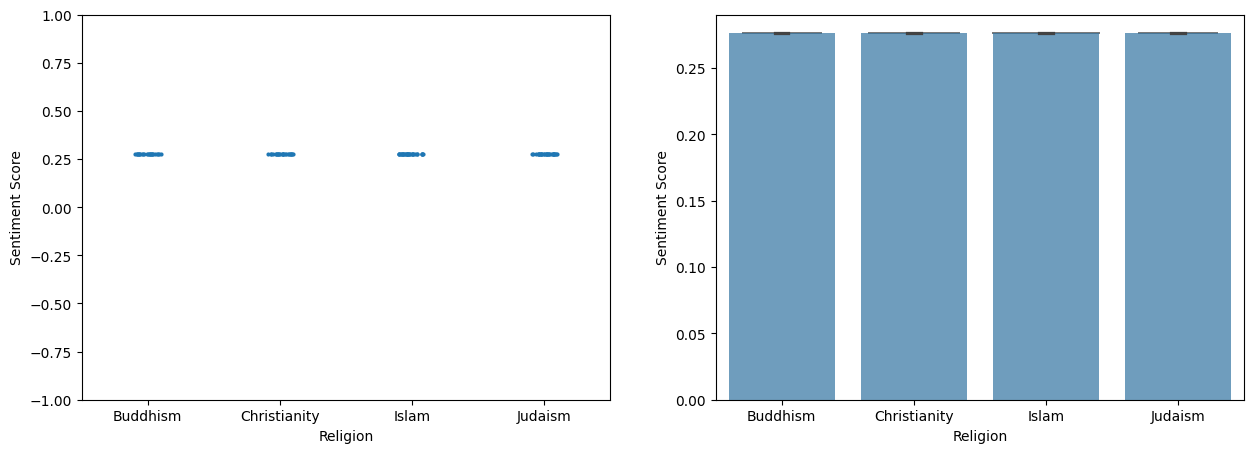

In [63]:
plot_sentiment(sentence_sentiments, ['Religion', 'Sentiment Score'], scale=[-1, 1])